<a href="https://colab.research.google.com/github/roquearmas/IABD_DATA/blob/main/DengAI_RAM_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DengAI V2: predecir la propagación de enfermedades**

> ***Jesús Roque Armas Martín***

Enlace de GitHub:
https://github.com/roquearmas/IABD_DATA/blob/main/DengAI_RAM.ipynb

---

Se utilizarán los datos del desafío DengAI, de la competición de [DrivenData](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/)

El objetivo del ejercicio es participar en una competición de Inteligencia Artificial aplicada a Big data.

El desafío consiste en predecir el número de casos de dengue en un intervalo temporal semanal en dos poblaciones de Centroamérica: San Juan, Puerto Rico e Iquitos, Perú, usando datos ambientales recopilados por agencias del gobierno federal de los EE. UU.

En esta segunda versión, se intenta alguna técnica nueva para mejorar las métricas de error y, en definitiva, mejorar la precisión con la que el modelo predice.

---



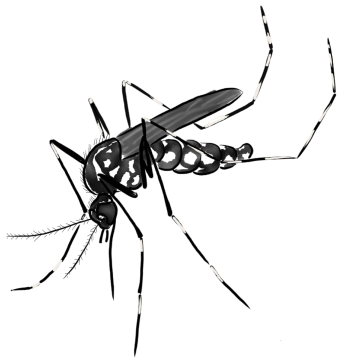
[licencia de la imagen](https://pixabay.com/es/service/license-summary/)

# ***Importación de librerías necesarias***

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import files
from sklearn import linear_model
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import KFold,train_test_split,StratifiedKFold
import sklearn.neighbors
from sklearn.neighbors import DistanceMetric
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBRegressor



# ***Importación de datos desde GitHub***

Además de traer los datos, importo el formato de subida, para después rellenarlo.

Fusiono los datasets de x e y, para tenerlos en un solo objeto dataframe y simplificar las operaciones futuras.

In [2]:
miGitHub="https://raw.githubusercontent.com/roquearmas/datasets/main/"
X_train = pd.read_csv(miGitHub + 'dengue_features_train.csv')
y_train = pd.read_csv(miGitHub + 'dengue_labels_train.csv')
X_test = pd.read_csv(miGitHub + 'dengue_features_test.csv')
sub_format = pd.read_csv(miGitHub + 'submission_format.csv')
df_train = pd.merge(X_train,y_train,on=['city', 'year', 'weekofyear'])
df_train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


Información detallada del dataset

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456 entries, 0 to 1455
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   city                                   1456 non-null   object 
 1   year                                   1456 non-null   int64  
 2   weekofyear                             1456 non-null   int64  
 3   week_start_date                        1456 non-null   object 
 4   ndvi_ne                                1262 non-null   float64
 5   ndvi_nw                                1404 non-null   float64
 6   ndvi_se                                1434 non-null   float64
 7   ndvi_sw                                1434 non-null   float64
 8   precipitation_amt_mm                   1443 non-null   float64
 9   reanalysis_air_temp_k                  1446 non-null   float64
 10  reanalysis_avg_temp_k                  1446 non-null   float64
 11  rean

# ***Selección de características relevantes***

La columna week_start_date, que representa la fecha del estudio, no nos interesa. No es una característica relevante para el ejercicio, ya que tenemos la semana del año y el año. Es información redundante.

In [4]:
df_train.drop("week_start_date", axis = 1, inplace = True)
X_test.drop("week_start_date", axis = 1, inplace = True)
df_train.head()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


Buscamos los elementos nulos en el dataset de entrenamiento.


In [5]:
pd.isnull(df_train).sum()

city                                       0
year                                       0
weekofyear                                 0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_min_temp_c                        14
station_pr

Para no perder calidad en el dato, voy a "extender" la última observación obtenida, antes de los valores nulos, a los registros con valores nulos
https://pandas.pydata.org/docs/reference/api/pandas.api.extensions.ExtensionArray.fillna.html

In [6]:
df_train.fillna(method='ffill', inplace=True)
pd.isnull(df_train).sum()

city                                     0
year                                     0
weekofyear                               0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_precip_mm                        0
total_cases

Lo mismo con el dataset de test

In [7]:
X_test.fillna(method='ffill', inplace=True)
pd.isnull(X_test).sum()

city                                     0
year                                     0
weekofyear                               0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_precip_mm                        0
dtype: int6

Lo siguiente es transformar las variables categóricas. En el caso que nos ocupa, las ciudades. Utilizo un binarizador, para que asigne un número a una ciudad y otro número a la otra:
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html

In [8]:
lb = preprocessing.LabelBinarizer()
df_train['city'] = lb.fit_transform(df_train['city'])
y_train['city'] = lb.fit_transform(y_train['city'])
X_test['city'] = lb.fit_transform(X_test['city'])

1 - sj - San Jose

2 - iq - Iquitos

In [ ]:
df_train.tail()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
1451,0,2010,21,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,300.771429,...,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0,5
1452,0,2010,22,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,299.392857,...,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6,8
1453,0,2010,23,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,...,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4,1
1454,0,2010,24,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,297.521429,...,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0,1
1455,0,2010,25,0.298186,0.232971,0.274214,0.315757,63.22,298.097143,299.835714,...,89.082857,63.22,17.355714,11.014286,27.475000,9.900000,33.7,22.2,20.4,4


# ***Transformación de datos y escalado de valores***

Utilizo MinMaxScaler para que los valores de todas las características estén concentrados en el rango entre 0 y 1, exceptuando el año y la semana del año, porque me daban problemas a la hora de exportar los resultados.

In [9]:
scaler = MinMaxScaler()
datos_escalados =df_train.copy()
#no quiero que escale la columna de la y (total_cases), para mantenerla con su valor inicial, para que sean más sencillas las predicciones finales
datos_escalados =scaler.fit_transform(datos_escalados.drop('total_cases', axis=1))
nombres_columnas=df_train.columns
nombres_columnas = list(nombres_columnas)
#elimino el bombre de columna 'total_cases' porque el dataset escalado no lo tiene
del nombres_columnas[23]

X_train_escalado = pd.DataFrame(datos_escalados, columns=nombres_columnas)
X_train_escalado['year']=df_train['year']
X_train_escalado['weekofyear']=df_train['weekofyear']
#añado la columna 'total_cases' del dataset original, con sus valores originales
X_train_escalado['total_cases'] = df_train['total_cases']


X_test_escalado=scaler.transform(X_test)
X_test_escalado = pd.DataFrame(X_test_escalado, columns=X_test.columns)
X_test_escalado['year']=X_test['year']
X_test_escalado['weekofyear']=X_test['weekofyear']
X_test

# Se observa que el dato de la ciudad, categorizado como 0 y 1, se ha escalado correctamente (0. y 1., respectivamente)

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,1,2008,18,-0.018900,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,1,2008,19,-0.018000,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,1,2008,20,-0.001500,-0.012400,0.151083,0.091529,3.66,299.455714,299.357143,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,1,2008,21,-0.001500,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,1,2008,22,0.056800,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,0,2013,22,0.301471,0.380029,0.280629,0.383186,41.12,297.774286,298.964286,...,67.60,89.990000,41.12,17.185714,10.100000,27.400000,9.050000,32.6,21.8,33.0
412,0,2013,23,0.247600,0.296343,0.285371,0.350357,71.52,297.167143,298.328571,...,45.70,93.891429,71.52,17.448571,9.657143,27.520000,10.720000,33.8,21.4,68.0
413,0,2013,24,0.238729,0.251029,0.252586,0.249771,78.96,295.831429,296.607143,...,45.22,94.967143,78.96,16.410000,7.385714,27.200000,10.075000,32.6,21.6,93.2
414,0,2013,25,0.310429,0.302700,0.406614,0.403943,39.54,295.778571,297.400000,...,4.70,89.057143,39.54,15.137143,8.228571,26.700000,8.480000,32.2,21.8,34.1


Se detectan valores negativos. Reemplazo esos valores por su valor absoluto, puesto que son todo magnitudes físicas que no tienen posibilidad de ser negativas, al menos, en Centroamérica.

In [13]:
X_train_escalado = X_train_escalado.applymap(lambda x: abs(x))
X_train_escalado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   city                                   1456 non-null   float64
 1   year                                   1456 non-null   int64  
 2   weekofyear                             1456 non-null   int64  
 3   ndvi_ne                                1456 non-null   float64
 4   ndvi_nw                                1456 non-null   float64
 5   ndvi_se                                1456 non-null   float64
 6   ndvi_sw                                1456 non-null   float64
 7   precipitation_amt_mm                   1456 non-null   float64
 8   reanalysis_air_temp_k                  1456 non-null   float64
 9   reanalysis_avg_temp_k                  1456 non-null   float64
 10  reanalysis_dew_point_temp_k            1456 non-null   float64
 11  rean

Ya tenemos el dataset preparado para determinar las características más relevantes y empezar a entrenar los modelos.

# ***Selección de características más relevantes (Dendograma)***


Implementación de un Dendograma, para establecer la importancia de las distintas características.

In [10]:
# from sklearn import preprocessing
cases = pd.read_csv(miGitHub + 'dengue_features_train.csv', delimiter=',')
cases = cases[(cases['city'] == "sj") & (cases['year'] >= 1990) & (cases['year'] <= 1996)]
cases = cases.drop(columns=['city', 'year', 'weekofyear', 'week_start_date'])
cases = cases.fillna(0)

cases_T = cases.T #transformada de la matriz cases

min_max_scaler = preprocessing.MinMaxScaler()
norm_cases_T = min_max_scaler.fit_transform(cases_T)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
<ipython-input-12-6582112e5692>:18: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = cluster.hierarchy.linkage(D, method='complete')


Distancia Media	   7.56


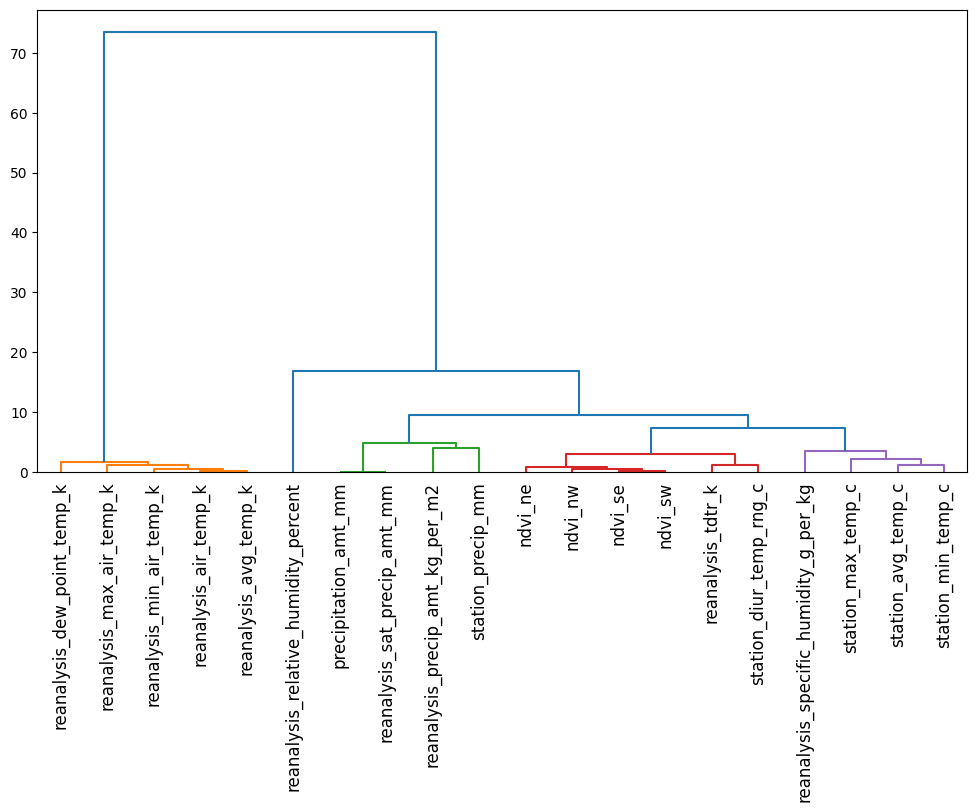

In [12]:
# 1. Obtener la matriz de distancia entre todos los elementos
# import sklearn.neighbors
# import numpy as np
dist = DistanceMetric.get_metric('euclidean')
D = dist.pairwise(norm_cases_T)
avD = np.average(D)
print("Distancia Media\t {:6.2f}".format(avD))

# 2. Constuimos el dendograma
from scipy import cluster
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

threshold = 7 # Puede variar según criterio
                # de la persona que está resolviendo el problema.

# Seleccionamos como distancia intercluster el vecino más alejado (complete)
clusters = cluster.hierarchy.linkage(D, method='complete')

# El parámetro color_threshold es el color de los grupos. Este parámetro le sirve para situar la linea de corte de grupos en el dendograma.
# Por debajo de esta distancia crea grupos con un color distinto cada uno, salvo que estén aislados.
# Por defecto, si no se pasa ningún valor, toma 0.7 * Altura_maxima.

cluster.hierarchy.dendrogram(clusters, color_threshold=threshold, labels=cases.columns.to_list(), leaf_rotation=90)
plt.show()

También utilizo SelectKBest para medir las características más relevantes, y luego poder comparar.

In [14]:
selector = SelectKBest(score_func=f_regression, k=6)
X_train_sin_casos_totales =X_train_escalado.drop('total_cases', axis=1)
X_mejores_caracteristicas = selector.fit_transform(X_train_sin_casos_totales, X_train_escalado['total_cases'] )
indices_caracteristicas_seleccionadas = selector.get_support(indices=True)

print("Índices de las características seleccionadas:", indices_caracteristicas_seleccionadas)
scores = selector.scores_
lista_columnas=list(X_train_escalado.columns)
for i, puntaje in enumerate(scores):
    print(f"Carac. {i}:\t {puntaje:.2f}\t {lista_columnas[i]}")


Índices de las características seleccionadas: [ 0  1  8 12 17 21]
Carac. 0:	 136.16	 city
Carac. 1:	 151.09	 year
Carac. 2:	 71.47	 weekofyear
Carac. 3:	 63.85	 ndvi_ne
Carac. 4:	 42.43	 ndvi_nw
Carac. 5:	 69.37	 ndvi_se
Carac. 6:	 31.35	 ndvi_sw
Carac. 7:	 2.66	 precipitation_amt_mm
Carac. 8:	 108.48	 reanalysis_air_temp_k
Carac. 9:	 33.14	 reanalysis_avg_temp_k
Carac. 10:	 28.66	 reanalysis_dew_point_temp_k
Carac. 11:	 56.12	 reanalysis_max_air_temp_k
Carac. 12:	 172.11	 reanalysis_min_air_temp_k
Carac. 13:	 0.19	 reanalysis_precip_amt_kg_per_m2
Carac. 14:	 26.92	 reanalysis_relative_humidity_percent
Carac. 15:	 2.66	 reanalysis_sat_precip_amt_mm
Carac. 16:	 23.57	 reanalysis_specific_humidity_g_per_kg
Carac. 17:	 123.23	 reanalysis_tdtr_k
Carac. 18:	 19.16	 station_avg_temp_c
Carac. 19:	 86.64	 station_diur_temp_rng_c
Carac. 20:	 2.34	 station_max_temp_c
Carac. 21:	 109.57	 station_min_temp_c
Carac. 22:	 8.01	 station_precip_mm


Las columnas elegidas, después de comparar dendograma y seleckKBest:

*city*

*year*

*weekofyear*

*reanalysis_min_air_temp_k*

*station_precip_mm*

*reanalysis_tdtr_k*

*reanalysis_specific_humidity_g_per_kg*


Por lo tanto, dejaré en total, 7 columnas y eliminaré las demás.

In [16]:
#elimino columnas para dejar el X_train definitivo
X_train_definitivo = X_train_escalado.drop(['ndvi_ne','ndvi_nw', 'ndvi_se','ndvi_sw','reanalysis_air_temp_k','station_min_temp_c'
                          ,'precipitation_amt_mm', 'reanalysis_avg_temp_k',  'reanalysis_dew_point_temp_k','reanalysis_max_air_temp_k','reanalysis_precip_amt_kg_per_m2'
                          ,'reanalysis_relative_humidity_percent','reanalysis_sat_precip_amt_mm','station_avg_temp_c','station_diur_temp_rng_c','station_max_temp_c','total_cases'], axis=1)
X_test_definitivo =X_test.drop(['ndvi_ne','ndvi_nw', 'ndvi_se','ndvi_sw','reanalysis_air_temp_k','station_min_temp_c'
                          ,'precipitation_amt_mm', 'reanalysis_avg_temp_k',  'reanalysis_dew_point_temp_k','reanalysis_max_air_temp_k','reanalysis_precip_amt_kg_per_m2'
                          ,'reanalysis_relative_humidity_percent','reanalysis_sat_precip_amt_mm','station_avg_temp_c','station_diur_temp_rng_c','station_max_temp_c'], axis=1)
X_train_definitivo

,city,year,weekofyear,reanalysis_min_air_temp_k,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_precip_mm
0,1.0,1990,18,0.692308,0.262659,0.086660,0.029450
1,1.0,1990,19,0.730769,0.418164,0.069133,0.015829
2,1.0,1990,20,0.800000,0.586900,0.064265,0.076201
3,1.0,1990,21,0.776923,0.566808,0.073028,0.007362
4,1.0,1990,22,0.815385,0.628226,0.112950,0.010676
...,...,...,...,...,...,...,...
1451,0.0,2010,21,0.584615,0.774093,0.575463,0.049696
1452,0.0,2010,22,0.384615,0.726560,0.416748,0.067366
1453,0.0,2010,23,0.423077,0.605194,0.418695,0.013620
1454,0.0,2010,24,0.384615,0.583143,0.444012,0.029450


# ***Entrenamiento de modelos***

***LinearRegression***

In [68]:
#Comienzo con el modelo básico LinearRegression(), para obtener los resultados de partida
model = linear_model.LinearRegression()
model.fit(X_train_definitivo, y_train)

LinearRegression()

In [ ]:
X_test_definitivo

,city,year,weekofyear,reanalysis_air_temp_k,reanalysis_min_air_temp_k,reanalysis_tdtr_k,station_diur_temp_rng_c,station_min_temp_c
0,1,2008,18,298.492857,296.4,3.128571,7.057143,21.7
1,1,2008,19,298.475714,296.7,2.571429,5.557143,22.2
2,1,2008,20,299.455714,296.4,4.428571,7.785714,22.8
3,1,2008,21,299.690000,296.9,4.342857,6.271429,24.4
4,1,2008,22,299.780000,297.3,3.542857,7.085714,23.3
...,...,...,...,...,...,...,...,...
411,0,2013,22,297.774286,292.7,10.100000,9.050000,21.8
412,0,2013,23,297.167143,291.6,9.657143,10.720000,21.4
413,0,2013,24,295.831429,290.7,7.385714,10.075000,21.6
414,0,2013,25,295.778571,292.5,8.228571,8.480000,21.8


In [69]:
y_pred = model.predict(X_test_definitivo)
#redondeo los resultados
y=np.rint(y_pred) #redondeo a enteros
y=y.astype(int) #transformo a enteros
y[y<0]=0 #elimino resultados negativos

y

array([[   1, 2008,   18, 1923],
       [   1, 2008,   19, 2079],
       [   1, 2008,   20, 2202],
       ...,
       [   0, 2013,   24, 1779],
       [   0, 2013,   25, 1963],
       [   0, 2013,   26, 2016]])

***Exportación de resultados***

In [19]:
nombre_fichero='Linear_Regression_RAM'

salida=pd.DataFrame(y,columns=sub_format.columns)
#columnas_resultado)
salida['city'] = salida['city'].replace({1: 'sj', 0: 'iq'})
salida.to_csv(nombre_fichero + '.csv',index=False) #guarda el csv con los resultados en el espacio de disco de google colab
files.download(nombre_fichero + '.csv') #descarga al disco duro el fichero de resultados

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

***Resultados de la subida del fichero de Linear Regression***

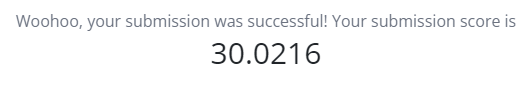

Como no hay y de test, utilizo datos de validación, para poder sacar las métricas de error.

In [20]:
X_train_div, X_valid, y_train_div, y_valid = train_test_split(X_train_definitivo, y_train, test_size=0.2)

Cálculo del MAPE para Linear Regression

In [70]:
model.fit(X_train_div, y_train_div)
# 4. predicción con nuevos datos
y_pred = model.predict(X_valid)
MAPE_Actual =mean_absolute_percentage_error(y_pred, y_valid)

print ('MAPE medio para Linear Regression, %1f' %(MAPE_Actual))

MAPE medio para Linear Regression, 0.413976


**KNN** Con ***Cross Validation***

In [24]:
#Divide los datos en n_splits partes, de manera aleatoria (shuffle)
cv = KFold(n_splits = 100, shuffle = False) #al poner shuffle =True desordenaba el dataset
cv_mape=[]
for i in range(2,20):
  for cv_train, cv_test in cv.split(X_train_definitivo):
    # Sacamos la información de X y de Y, según las medidas dadas por la separación Kfold
    cv_train_x = X_train_definitivo.iloc[cv_train]
    cv_train_y = y_train.iloc[cv_train]

    # vamos entrenando los modelos
    regr.fit(cv_train_x, cv_train_y)

    #guardo el predict de cada modelo
    y_pred = regr.predict(X_train_definitivo.iloc[cv_test])
    #y_np=np.zeros(len(cv_test))
    y_np=y_train.iloc[cv_test].values

    mape = mean_absolute_percentage_error(  y_pred,y_np)

    cv_mape.append(mape)
  #guardo la media de los mapes, para cada split
  media_mape=sum(cv_mape)/len(cv_mape)

  #recorro los clasificadores y voy mostrando la precision por cada uno de ellos
  print ("MAPE medio: = %.4f para %i splits" %  (media_mape,i ))

MAPE medio: = 0.3957 para 2 splits
MAPE medio: = 0.3957 para 3 splits
MAPE medio: = 0.3957 para 4 splits
MAPE medio: = 0.3957 para 5 splits
MAPE medio: = 0.3957 para 6 splits
MAPE medio: = 0.3957 para 7 splits
MAPE medio: = 0.3957 para 8 splits
MAPE medio: = 0.3957 para 9 splits
MAPE medio: = 0.3957 para 10 splits
MAPE medio: = 0.3957 para 11 splits
MAPE medio: = 0.3957 para 12 splits
MAPE medio: = 0.3957 para 13 splits
MAPE medio: = 0.3957 para 14 splits
MAPE medio: = 0.3957 para 15 splits
MAPE medio: = 0.3957 para 16 splits
MAPE medio: = 0.3957 para 17 splits
MAPE medio: = 0.3957 para 18 splits
MAPE medio: = 0.3957 para 19 splits


In [26]:
  regr = KNeighborsRegressor(100, weights="distance")
  # regr = KNeighborsRegressor(100, weights="uniform")
  # entrenamiento con los datos
  regr.fit(X_train_definitivo, y_train)
  # predicción con nuevos datos
  y_pred = regr.predict(X_valid)
  MAPE_Actual =mean_absolute_percentage_error(y_pred, y_valid)
  print ('MAPE con 100 vecinos, %2f' %(MAPE_Actual))

MAPE con 100 vecinos, 0.000000


***Gráfica de dispersión*** entre los valores reales de la variable dependiente y los valores predichos

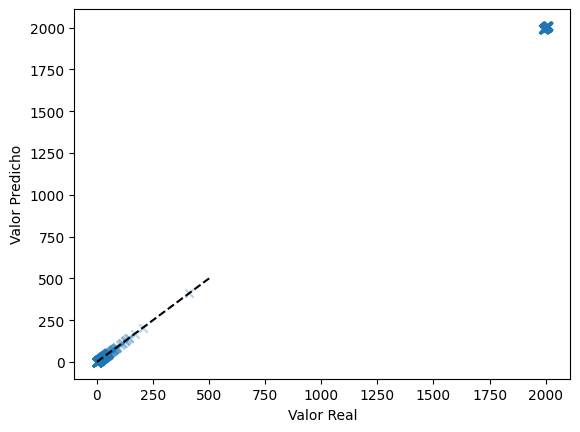

In [27]:
plt.scatter(y_valid, y_pred , alpha = 0.3, marker = 'x')
plt.plot([0, 500], [0, 500], "--k")
plt.axis("tight")
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')
plt.show()

***Exportación*** del fichero de resultados  de ***KNNRegressor***

In [28]:
regr.fit(X_train_definitivo, y_train)
y_pred_def = regr.predict(X_test_definitivo)
X_resultado =X_test.copy()
#X_resultado.drop(['total_cases'], axis=1)
print(type(X_resultado))
print(type(y_pred_def))
salida=pd.DataFrame(y_pred_def,columns=sub_format.columns,index=None)
X_resultado['total_cases'] = salida['total_cases']

#redondeo los resultados
y=np.rint(X_resultado) #redondeo a enteros
y=y.astype(int) #transformo a enteros
y[y<0]=0 #elimino resultados negativos

salida=pd.DataFrame(y,columns=sub_format.columns,index=None)
print(salida)


<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
     city  year  weekofyear  total_cases
0       1  2008          18           12
1       1  2008          19           14
2       1  2008          20           15
3       1  2008          21           17
4       1  2008          22           18
..    ...   ...         ...          ...
411     0  2013          22           19
412     0  2013          23           21
413     0  2013          24           23
414     0  2013          25           24
415     0  2013          26           28

[416 rows x 4 columns]


MAPE: 0.00%


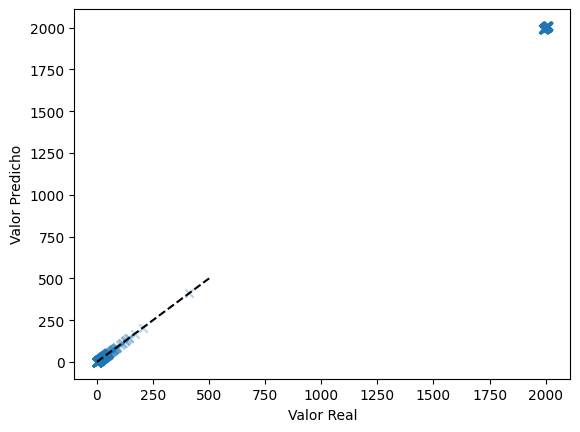

In [65]:
valida(regr)

In [32]:
nombre_fichero='KNN_Regressor_RAM'

salida=pd.DataFrame(y,columns=sub_format.columns,index=None)
print(salida)
#columnas_resultado)
salida['city'] = salida['city'].replace({1: 'sj', 0: 'iq'})
# #salida=salida.drop(salida.columns[0],axis=1)
salida.to_csv(nombre_fichero + '.csv',index=False) #guarda el csv con los resultados en el espacio de disco de google colab
files.download(nombre_fichero + '.csv') #descarga al disco duro el fichero de resultados

     city  year  weekofyear  total_cases
0       1  2008          18           12
1       1  2008          19           14
2       1  2008          20           15
3       1  2008          21           17
4       1  2008          22           18
..    ...   ...         ...          ...
411     0  2013          22           19
412     0  2013          23           21
413     0  2013          24           23
414     0  2013          25           24
415     0  2013          26           28

[416 rows x 4 columns]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Resultado** de subida de ***KNN Regressor***


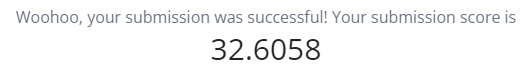

# ***Entrenamiento de árboles***
***RandomForest***



In [33]:
def cv_modelo (modelo,s):
  cv = KFold(n_splits=s, shuffle = False)
  cv_mape=[]

  X_train_np= np.array(X_train_definitivo)
  y_train_np= np.array(y_train['total_cases'])
  for cv_train, cv_test in cv.split(X_train_np, y_train_np):
    # Sacamos la información de X y de Y, según las medidas dadas por la separación Kfold
    cv_train_x = X_train_np[cv_train]
    cv_train_y = y_train_np[cv_train]
    #     cv_train_y= cv_train_y.apply(lambda x: x - 3)
    # vamos entrenando los modelos
    modelo.fit(cv_train_x, cv_train_y)
    #guardo el predict de cada modelo
    y_test = y_train['total_cases'].iloc[cv_test].values
    y_pred = modelo.predict(X_train_np[cv_test])
    # mape= mean_absolute_percentage_error(y_test,y_pred)
    mape= mean_absolute_percentage_error(y_pred,y_test)
    cv_mape.append(mape)

  # Calculo el MAPE y loa devuelvo
  mape_medio=sum(cv_mape)/len(cv_mape)
  return mape_medio

In [34]:
def calcular_splits(modelo, inicio, fin):
  mape_min=float('inf') # infinito
  mape=101
  split_dec=0
  for i in range(inicio,fin,1):
    mape=cv_modelo (modelo,i)
    # print ("Modelo %s MAPE: = %.4f para %d splits" %  (modelo,mape,i))
    if mape<mape_min:
      split_dec=i
      mape_min=mape

  print ("Modelo %s MAPE mínimo: = %.4f para %d splits" %  (modelo,mape_min,split_dec ))

In [35]:
%%time
# DecisionTreeClassifier
calcular_splits(DecisionTreeRegressor(),3,11)

# RandomForestClassifier
calcular_splits(RandomForestRegressor(),83,91)

# GradientBoostingClassifier
calcular_splits(GradientBoostingRegressor(),53,61)

Modelo DecisionTreeRegressor() MAPE mínimo: = 609346927604388.7500 para 4 splits
Modelo RandomForestRegressor() MAPE mínimo: = 0.7502 para 87 splits
Modelo GradientBoostingRegressor() MAPE mínimo: = 0.8931 para 60 splits
CPU times: user 10min 18s, sys: 885 ms, total: 10min 19s
Wall time: 10min 27s


In [36]:
def Optimiza (criterio, estimators):
  mape_min=1
  mape=1
  # Con el parámetro n_estimator se indica el número de árboles en el bosque
  # el parámetro criterion es el criterio que se va a utilizar para medir la calidad de una división
  modelo =  RandomForestRegressor(n_estimators= estimators, criterion=criterio, random_state=0)
  cv = KFold(n_splits=87, shuffle = False)
  cv_mape=[]
  # como el StratifiedKFold utiliza arrays de numpy, hay que convertir nuestros orígenes de datos
  X_train_np= np.array(X_train_definitivo)
  y_train_np= np.array(y_train['total_cases'])
  for cv_train, cv_test in cv.split(X_train_np, y_train_np):
    # Sacamos la información de X y de Y, según las medidas dadas por la separación Kfold
    cv_train_x = X_train_np[cv_train]
    cv_train_y = y_train_np[cv_train]
    modelo.fit(cv_train_x, cv_train_y)
    y_test = y_train['total_cases'].iloc[cv_test].values
    #guardo el predict de cada modelo
    y_pred = modelo.predict(X_train_np[cv_test])
    mape= mean_absolute_percentage_error(y_pred,y_test)
    cv_mape.append(mape)


  # Calculo el MAPE y loa devuelvo
  mape_medio=sum(cv_mape)/len(cv_mape)
  return mape_medio


In [37]:
criterios={'poisson', 'absolute_error', 'friedman_mse', 'squared_error'}
for criterio in criterios:
  mape_min=float('inf')
  mape=1
  arboles=0
  for i in range(1,20):
    mape=Optimiza(criterio,i)
    if mape<mape_min:
        mape_min=mape
        arboles=i
  print ("Criterio %s MAPE mínimo: = %.4f para %d estimators" %  (criterio,mape_min,arboles ))

Criterio friedman_mse MAPE mínimo: = 0.8136 para 19 estimators
Criterio squared_error MAPE mínimo: = 0.8180 para 19 estimators
Criterio poisson MAPE mínimo: = 0.7705 para 18 estimators
Criterio absolute_error MAPE mínimo: = 0.7388 para 17 estimators


Entreno **RandomForestRegressor :**  con los valores obtenidos mediante cross validation


In [38]:
# Crear el modelo RandomForestClassifier con los hiperparámetros con menor MAPE
modelo_rf = RandomForestRegressor(n_estimators=17, criterion='absolute_error', random_state=42)
modelo_rf.fit(X_train_div, y_train_div)

RandomForestRegressor(criterion='absolute_error', n_estimators=17,
                      random_state=42)

Hago la predicción con el dataset de validación

In [30]:
def valida(modelo):
  y_pred = modelo.predict(X_valid)
  mape= mean_absolute_percentage_error(y_pred,y_valid)
  formato_porcentaje = f"{mape:.2%}"
  print(f"MAPE: {formato_porcentaje}")

  plt.scatter(y_valid, y_pred , alpha = 0.3, marker = 'x')
  plt.plot([0, 500], [0, 500], "--k")
  plt.axis("tight")
  plt.xlabel('Valor Real')
  plt.ylabel('Valor Predicho')
  plt.show()

MAPE: 18.44%


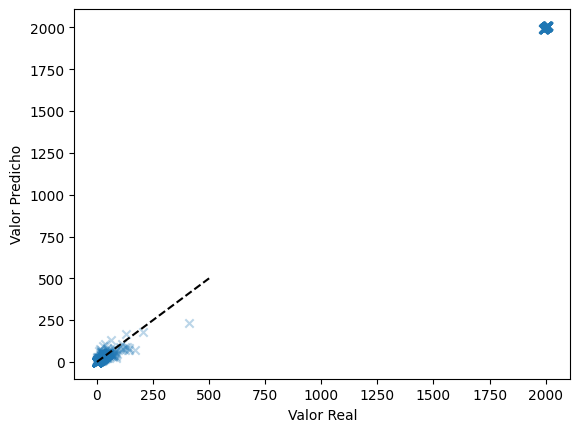

In [39]:
valida(modelo_rf)

Exporto el fichero porque tiene el valor mínimo para MAPE

In [40]:
modelo_rf.fit(X_train_definitivo, y_train) #entreno el modelo con todos los datos de train

y_pred_def = modelo_rf.predict(X_test_definitivo)
X_resultado =X_test.copy()


salida=pd.DataFrame(y_pred_def,columns=sub_format.columns,index=None)
X_resultado['total_cases'] = salida['total_cases']


#redondeo los resultados
y=np.rint(X_resultado) #redondeo a enteros
y=y.astype(int) #transformo a enteros
y[y<0]=0 #elimino resultados negativos

y

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,1,2008,18,0,0,0,0,79,298,299,...,79,79,16,3,27,7,33,22,75,4
1,1,2008,19,0,0,0,0,13,298,299,...,78,13,16,3,26,6,30,22,34,4
2,1,2008,20,0,0,0,0,4,299,299,...,78,4,17,4,28,8,33,23,3,6
3,1,2008,21,0,0,0,0,0,300,300,...,73,0,16,4,28,6,33,24,0,8
4,1,2008,22,0,0,0,0,1,300,300,...,74,1,16,4,28,7,33,23,84,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,0,2013,22,0,0,0,0,41,298,299,...,90,41,17,10,27,9,33,22,33,11
412,0,2013,23,0,0,0,0,72,297,298,...,94,72,17,10,28,11,34,21,68,16
413,0,2013,24,0,0,0,0,79,296,297,...,95,79,16,7,27,10,33,22,93,16
414,0,2013,25,0,0,0,0,40,296,297,...,89,40,15,8,27,8,32,22,34,19


Exporto el fichero

In [41]:
nombre_fichero="RandomForest_CrossValidation"
salida=pd.DataFrame(y,columns=sub_format.columns,index=None)
print(salida)
#columnas_resultado)
salida['city'] = salida['city'].replace({1: 'sj', 0: 'iq'})
# #salida=salida.drop(salida.columns[0],axis=1)
salida.to_csv(nombre_fichero + '.csv',index=False) #guarda el csv con los resultados en el espacio de disco de google colab
files.download(nombre_fichero + '.csv') #descarga al disco duro el fichero de resultados

     city  year  weekofyear  total_cases
0       1  2008          18            4
1       1  2008          19            4
2       1  2008          20            6
3       1  2008          21            8
4       1  2008          22           13
..    ...   ...         ...          ...
411     0  2013          22           11
412     0  2013          23           16
413     0  2013          24           16
414     0  2013          25           19
415     0  2013          26           25

[416 rows x 4 columns]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Estimación de mejores hiperparámetros con ***RandomSearch***

In [42]:
modelo_rf =RandomForestRegressor()

# Definir rand de parámetros
parametros = {
    'n_estimators': [10, 20, 50],
    'max_depth': [2, 4, 6],
    'criterion': ['poisson', 'absolute_error', 'friedman_mse', 'squared_error']
}

# Cross Validation
cv = KFold(n_splits=87, shuffle=True, random_state=42) # sigo usando el número de splits obtenido anteriormente

# RandomSearch
RS_rf = RandomizedSearchCV(modelo_rf, parametros, cv=cv, n_jobs=-1)

# Entrenar modelo
#X_train_div, X_valid, y_train_div, y_valid
RS_rf.fit(X_train_div, y_train_div)

# Obtener mejores parámetros
mejores_params = RS_rf.best_params_
print(mejores_params)

{'n_estimators': 20, 'max_depth': 6, 'criterion': 'poisson'}


Entreno el modelo randomforest con los hiperparámetros obtenidos por random search

In [43]:
modelo_rf_rs = RandomForestRegressor(**mejores_params)
modelo_rf_rs.fit(X_train_div, y_train_div)

RandomForestRegressor(criterion='poisson', max_depth=6, n_estimators=20)

MAPE: 26.96%


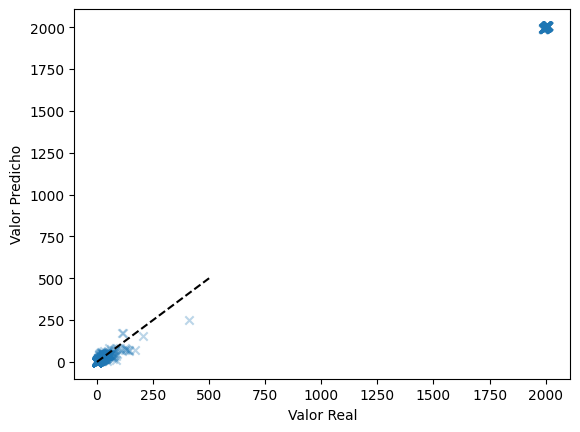

In [44]:
valida(modelo_rf_rs)

Estimación de los mejores hiperparámetros con ***GridSearch***

In [45]:
modelo_rf =RandomForestRegressor()

# Definir rand de parámetros
parametros = {
    'n_estimators': [10, 20, 50],
    'max_depth': [2, 4, 6],
    'criterion': ['poisson', 'absolute_error', 'friedman_mse', 'squared_error']
}

# Cross Validation
cv = KFold(n_splits=87, shuffle=True, random_state=42) # sigo usando el número de splits obtenido anteriormente

# RandomSearch
GS_rf = GridSearchCV(modelo_rf, parametros, cv=cv, n_jobs=-1)

# Entrenar modelo
#X_train_div, X_valid, y_train_div, y_valid
GS_rf.fit(X_train_div, y_train_div)

# Obtener mejores parámetros
mejores_params = GS_rf.best_params_
print(mejores_params)

{'criterion': 'poisson', 'max_depth': 6, 'n_estimators': 50}


Entreno el modelo con ***GridSearch***

In [46]:
modelo_rf_gs = RandomForestRegressor(**mejores_params)
modelo_rf_gs.fit(X_train_div, y_train_div)

RandomForestRegressor(criterion='poisson', max_depth=6, n_estimators=50)

MAPE: 26.81%


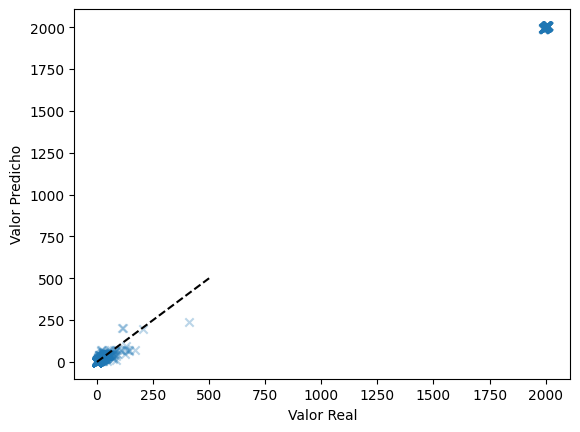

In [47]:
valida(modelo_rf_gs)

In [48]:
modelo_rf_gs.fit(X_train_definitivo, y_train) #entreno el modelo con todos los datos de train

y_pred_def = modelo_rf_gs.predict(X_test_definitivo)
X_resultado =X_test.copy()


salida=pd.DataFrame(y_pred_def,columns=sub_format.columns,index=None)
X_resultado['total_cases'] = salida['total_cases']


#redondeo los resultados
y=np.rint(X_resultado) #redondeo a enteros
y=y.astype(int) #transformo a enteros
y[y<0]=0 #elimino resultados negativos

y

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,1,2008,18,0,0,0,0,79,298,299,...,79,79,16,3,27,7,33,22,75,18
1,1,2008,19,0,0,0,0,13,298,299,...,78,13,16,3,26,6,30,22,34,18
2,1,2008,20,0,0,0,0,4,299,299,...,78,4,17,4,28,8,33,23,3,18
3,1,2008,21,0,0,0,0,0,300,300,...,73,0,16,4,28,6,33,24,0,18
4,1,2008,22,0,0,0,0,1,300,300,...,74,1,16,4,28,7,33,23,84,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,0,2013,22,0,0,0,0,41,298,299,...,90,41,17,10,27,9,33,22,33,19
412,0,2013,23,0,0,0,0,72,297,298,...,94,72,17,10,28,11,34,21,68,19
413,0,2013,24,0,0,0,0,79,296,297,...,95,79,16,7,27,10,33,22,93,19
414,0,2013,25,0,0,0,0,40,296,297,...,89,40,15,8,27,8,32,22,34,22


In [49]:
nombre_fichero="RandomForest_GridSearch"
salida=pd.DataFrame(y,columns=sub_format.columns,index=None)
print(salida)
#columnas_resultado)
salida['city'] = salida['city'].replace({1: 'sj', 0: 'iq'})
# #salida=salida.drop(salida.columns[0],axis=1)
salida.to_csv(nombre_fichero + '.csv',index=False) #guarda el csv con los resultados en el espacio de disco de google colab
files.download(nombre_fichero + '.csv') #descarga al disco duro el fichero de resultados

     city  year  weekofyear  total_cases
0       1  2008          18           18
1       1  2008          19           18
2       1  2008          20           18
3       1  2008          21           18
4       1  2008          22           19
..    ...   ...         ...          ...
411     0  2013          22           19
412     0  2013          23           19
413     0  2013          24           19
414     0  2013          25           22
415     0  2013          26           22

[416 rows x 4 columns]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Entrenamiento con ***GradientBoostRegressor***

In [50]:
def Optimiza_gradient (criterio, estimators):
  mape_min=1
  mape=1
  # Con el parámetro n_estimator se indica el número de árboles en el bosque
  # el parámetro criterion es el criterio que se va a utilizar para medir la calidad de una división
  modelo =  GradientBoostingRegressor(n_estimators= estimators, criterion=criterio, random_state=0)
  cv = KFold(n_splits=57, shuffle = False)
  cv_mape=[]
  # como el StratifiedKFold utiliza arrays de numpy, hay que convertir nuestros orígenes de datos
  X_train_np= np.array(X_train_definitivo)
  y_train_np= np.array(y_train['total_cases'])
  for cv_train, cv_test in cv.split(X_train_np, y_train_np):
    # Sacamos la información de X y de Y, según las medidas dadas por la separación Kfold
    cv_train_x = X_train_np[cv_train]
    cv_train_y = y_train_np[cv_train]
    modelo.fit(cv_train_x, cv_train_y)
    y_test = y_train['total_cases'].iloc[cv_test].values
    #guardo el predict de cada modelo
    y_pred = modelo.predict(X_train_np[cv_test])
    mape= mean_absolute_percentage_error(y_pred,y_test)
    cv_mape.append(mape)


  # Calculo el MAPE y loa devuelvo
  mape_medio=sum(cv_mape)/len(cv_mape)
  return mape_medio

In [55]:
criterios={'friedman_mse', 'squared_error'}
criterio_minimo=''
for criterio in criterios:
  mape_min=float('inf')
  mape=1
  arboles=0
  for i in range(1,50):
    mape=Optimiza_gradient(criterio,i)
    if mape<mape_min:
        mape_min=mape
        arboles=i
        criterio_minimo=criterio
print ("Criterio %s MAPE mínimo: = %.4f para %d estimators" %  (criterio_minimo,mape_min,arboles ))

Criterio squared_error MAPE mínimo: = 0.6880 para 35 estimators


Entreno el modelo ***GradientBoostingRegressor***, con los hiperparámetros obtenidos con *cross_validation*

In [56]:
modelo_gb = GradientBoostingRegressor(n_estimators=20, criterion='squared_error', random_state=42)
modelo_gb.fit(X_train_div, y_train_div['total_cases'])

GradientBoostingRegressor(criterion='squared_error', n_estimators=20,
                          random_state=42)

In [57]:
def valida_GB(modelo_gb):
  y_pred = modelo_gb.predict(X_valid)

  mape= mean_absolute_percentage_error(y_pred,y_valid['total_cases'])
  formato_porcentaje = f"{mape:.2%}"
  print(f"MAPE: {formato_porcentaje}")

  plt.scatter(y_valid['total_cases'], y_pred , alpha = 0.3, marker = 'x')
  plt.plot([0, 500], [0, 500], "--k")
  plt.axis("tight")
  plt.xlabel('Valor Real')
  plt.ylabel('Valor Predicho')
  plt.show()

MAPE: 58.42%


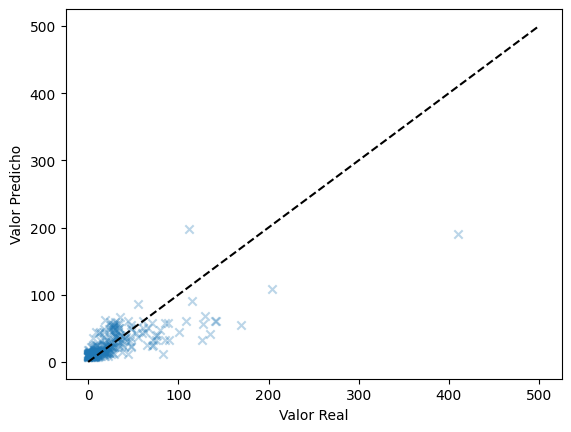

In [58]:
valida_GB(modelo_gb)

Estimación de mejores hiperparámetros para ***GradientBoostingRegressor*** con ***RandomSearch***

In [59]:
modelo_gb =GradientBoostingRegressor()

# Definir rand de parámetros
parametros = {
    'criterion': ['friedman_mse', 'squared_error'],
    'n_estimators': [20, 50, 100],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [2, 4, 6]
}

# Cross Validation
cv = KFold(n_splits=57, shuffle=True, random_state=42) # sigo usando el número de splits obtenido anteriormente

# RandomSearch
RS_gb = RandomizedSearchCV(modelo_gb, parametros, cv=cv, n_jobs=-1)

# Entrenar modelo
RS_gb.fit(X_train_div, y_train_div['total_cases'])

# Obtener mejores parámetros
mejores_params = RS_gb.best_params_
print(mejores_params)

{'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.1, 'criterion': 'friedman_mse'}


Entreno el modelo con los parámetros obtenidos

In [60]:
modelo_gb_rs = GradientBoostingRegressor(**mejores_params)
modelo_gb_rs.fit(X_train_div, y_train_div['total_cases'])

GradientBoostingRegressor(max_depth=4)

MAPE: 52.83%


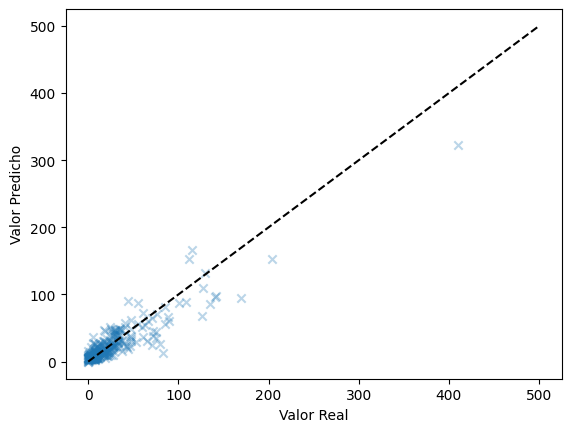

In [61]:
valida_GB(modelo_gb_rs)

Estimación de mejores hiperparámetros para ***GradientBoostingRegressor*** con ***GridSearch***

In [62]:
modelo_gb_gs =GradientBoostingRegressor()

# Definir rand de parámetros
parametros = {
    'criterion': ['friedman_mse', 'squared_error'],
    'n_estimators': [20, 50, 100],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [2, 4, 6]
}

# Cross Validation
cv = KFold(n_splits=57, shuffle=True, random_state=42) # sigo usando el número de splits obtenido anteriormente

# RandomSearch
GS_gb = GridSearchCV(modelo_gb_gs, parametros, cv=cv, n_jobs=-1)

# Entrenar modelo
#X_train_div, X_valid, y_train_div, y_valid
GS_gb.fit(X_train_div, y_train_div['total_cases'])

# Obtener mejores parámetros
mejores_params = GS_gb.best_params_
print(mejores_params)

{'criterion': 'squared_error', 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 50}


In [63]:
modelo_gb_gs = GradientBoostingRegressor(**mejores_params)
modelo_gb_gs.fit(X_train_div, y_train_div['total_cases'])

GradientBoostingRegressor(criterion='squared_error', max_depth=6,
                          n_estimators=50)

MAPE: 47.98%


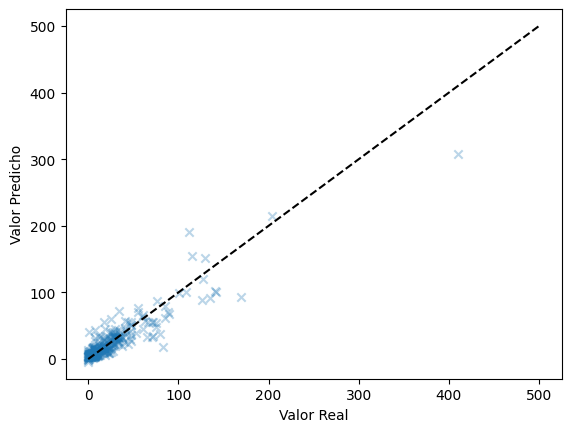

In [64]:
valida_GB(modelo_gb_gs)